In [ ]:
!pwd

/content


drive/  sample_data/


In [ ]:
cd drive/MyDrive/Projects/rl

/content/drive/MyDrive/Projects/rl


In [ ]:
# !git clone https://github.com/sainijagjit/DDPG-Pytorch.git

Cloning into 'DDPG-Pytorch'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 51 (delta 17), reused 46 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (51/51), 1.78 MiB | 12.15 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [ ]:
cd DDPG-Pytorch/

/content/drive/MyDrive/Projects/rl/DDPG-Pytorch


In [ ]:
# !apt-get install -y swig
!pip install gym box2d-py pygame


In [ ]:
!pip install --upgrade "numpy<2"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 33.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.0
    Uninstalling numpy-2.3.0:
      Successfully uninstalled numpy-2.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
dopamine-rl 4.1.2 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


In [ ]:
# point_particle_env.py

from typing import Optional
import numpy as np
import gym
from gym import spaces
from gym.utils import seeding
import pygame
from pygame import gfxdraw

class PointParticleEnv(gym.Env):
    """
    Continuous 2D navigation with interior obstacles and boundary walls.
    - State: [x, y, heading] (plus flattened obstacles if obs=True)
    - Action: heading angle in degrees [action_min, action_max]
    - Reward:
        * +goal_reward on reaching the goal
        * -obstacle_penalty if bumping an obstacle
        * -wall_penalty     if pushing against a boundary
        * otherwise = -distance_to_goal
    - Episode ends (terminated) on goal; truncated on time-limit.
    """
    metadata = {'render.modes': ['human', 'rgb_array']}

    def __init__(self,
                 size=(50, 50),
                 goal=None,
                 exploring_starts: bool=False,
                 obs: bool=False,
                 action_range=(0, 360),
                 max_episode_steps: int = 500,
                 obstacle_penalty: float = 10.0,
                 wall_penalty: float = 10.0,
                 goal_reward: float = 100.0):
        super().__init__()
        # —— seeding for reproducibility
        self.seed()

        # —— env parameters
        self.size = np.array(size, dtype=np.float32)
        self.speed = 5.0
        self.goal = np.array([45.0, 45.0], dtype=np.float32) \
                    if goal is None else np.array(goal, dtype=np.float32)
        self.exploring_starts = exploring_starts
        self.obs = obs
        self.action_min, self.action_max = action_range

        # —— penalties & rewards
        self.obstacle_penalty = obstacle_penalty
        self.wall_penalty     = wall_penalty
        self.goal_reward      = goal_reward

        # —— time‐limit bookkeeping
        self.max_episode_steps = max_episode_steps
        self.current_step      = 0

        # —— action & observation spaces
        self.action_space = spaces.Box(
            low  = np.array([self.action_min], dtype=np.float32),
            high = np.array([self.action_max], dtype=np.float32),
            dtype=np.float32
        )

        # define some interior rectangular obstacles (x1,y1,x2,y2)
        self.obstacles = [
            (12, 12, 25, 15),
            (25, 25, 27, 37)
        ]

        # observation space: [x, y, heading] + obstacles if obs=True
        if self.obs:
            obs_low  = np.zeros(4 * len(self.obstacles), dtype=np.float32)
            obs_high = np.concatenate((self.size, [360])).astype(np.float32)
            self.observation_space = spaces.Box(
                low  = np.concatenate(([0, 0, 0], obs_low)),
                high = np.concatenate((obs_high, obs_low + self.size[0])),
                dtype=np.float32
            )
        else:
            self.observation_space = spaces.Box(
                low  = np.array([0, 0, 0], dtype=np.float32),
                high = np.array([*self.size, 360], dtype=np.float32),
                dtype=np.float32
            )

        # internal
        self.state  = None
        self.screen = None

    def seed(self, seed: Optional[int]=None):
        """Gym-style seeding."""
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self, *, seed: Optional[int]=None, options=None):
        """Reset environment; return (obs, info)."""
        if seed is not None:
            self.seed(seed)
        self.current_step = 0

        if self.exploring_starts:
            x       = self.np_random.uniform(0, self.size[0])
            y       = self.np_random.uniform(0, self.size[1])
            heading = self.np_random.uniform(self.action_min, self.action_max)
        else:
            x, y, heading = 10.0, 10.0, 0.0

        if self.obs:
            flat_obs   = np.array(self.obstacles).flatten().astype(np.float32)
            self.state  = np.concatenate(([x, y, heading], flat_obs))
        else:
            self.state  = np.array([x, y, heading], dtype=np.float32)

        return self.state, {}

    def is_collision(self, x: float, y: float) -> bool:
        """Check interior obstacles only."""
        for x1, y1, x2, y2 in self.obstacles:
            if x1 <= x <= x2 and y1 <= y <= y2:
                return True
        return False

    def step(self, action):
        """Apply action, return (next_state, reward, terminated, truncated, info)."""
        self.current_step += 1

        new_state, reward, terminated, info = self._simulate_step(self.state, action)

        x, y = new_state[:2]
        # interior obstacle penalty
        if self.is_collision(x, y):
            reward -= self.obstacle_penalty
        # boundary wall penalty
        if not (0 <= x <= self.size[0] and 0 <= y <= self.size[1]):
            # (shouldn’t happen if we clip, but just in case)
            reward -= self.wall_penalty

        # goal bonus
        if terminated:
            reward += self.goal_reward

        # truncation on time-limit
        truncated = (self.current_step >= self.max_episode_steps)

        # update state
        self.state = new_state

        return new_state, reward, terminated, truncated, info

    def _simulate_step(self, state, action):
        """Compute next_state, base_reward, terminated (no penalties here)."""
        pos     = state[:2]
        heading = float(action[0])

        dx = self.speed * np.cos(np.radians(heading))
        dy = self.speed * np.sin(np.radians(heading))
        new_x = pos[0] + dx
        new_y = pos[1] + dy

        # detect interior obstacle or boundary
        hit_obstacle = self.is_collision(new_x, new_y)
        hit_wall     = not (0 <= new_x <= self.size[0] and 0 <= new_y <= self.size[1])

        # roll-back if collision or out-of-bounds
        if hit_obstacle or hit_wall:
            new_x, new_y = pos

        # clip to exact bounds
        new_x = np.clip(new_x, 0, self.size[0])
        new_y = np.clip(new_y, 0, self.size[1])

        if self.obs:
            obs_data  = state[3:]
            new_state = np.concatenate(([new_x, new_y, heading], obs_data))
        else:
            new_state = np.array([new_x, new_y, heading], dtype=np.float32)

        # base reward = negative distance to goal
        distance   = np.linalg.norm(new_state[:2] - self.goal)
        base_reward = -distance

        # termination when close to goal
        terminated = (distance < 5.0)

        return new_state, base_reward, terminated, {}

    def render(self, mode='human'):
        """Draw agent, goal, obstacles, and walls."""
        screen_size = 600
        scale = screen_size / max(self.size)

        if self.screen is None:
            pygame.init()
            self.screen = pygame.Surface((screen_size, screen_size))

        surf = pygame.Surface((screen_size, screen_size))
        surf.fill((22, 36, 71))  # background

        # draw boundary walls (as gray frame)
        wall_thick = 5
        pygame.draw.rect(surf, (100,100,100), (0, 0, screen_size, wall_thick))  # top
        pygame.draw.rect(surf, (100,100,100), (0, 0, wall_thick, screen_size))  # left
        pygame.draw.rect(surf, (100,100,100), (0, screen_size-wall_thick, screen_size, wall_thick))  # bottom
        pygame.draw.rect(surf, (100,100,100), (screen_size-wall_thick, 0, wall_thick, screen_size))  # right

        # draw goal
        gx = int(self.goal[0] * scale)
        gy = screen_size - int(self.goal[1] * scale)
        gfxdraw.filled_circle(surf, gx, gy, int(scale*2), (40,199,172))

        # draw obstacles
        for x1, y1, x2, y2 in self.obstacles:
            rx = int(x1*scale)
            ry = screen_size - int(y2*scale)
            w  = int((x2-x1)*scale)
            h  = int((y2-y1)*scale)
            pygame.draw.rect(surf, (128,128,128), (rx, ry, w, h))

        # draw agent
        ax = int(self.state[0]*scale)
        ay = screen_size - int(self.state[1]*scale)
        gfxdraw.filled_circle(surf, ax, ay, int(scale*1), (228,63,90))
        # heading line
        end_x = ax + int(10*np.cos(np.radians(self.state[2])))
        end_y = ay - int(10*np.sin(np.radians(self.state[2])))
        pygame.draw.line(surf, (255,255,255), (ax,ay), (end_x,end_y), 2)

        canvas = pygame.transform.flip(surf, False, True)
        self.screen.blit(canvas, (0,0))

        if mode=='human':
            pygame.display.flip()
            return None
        elif mode=='rgb_array':
            arr = pygame.surfarray.pixels3d(self.screen)
            return np.transpose(arr, (1,0,2)).astype(np.uint8)
        else:
            raise ValueError(f"Render mode {mode} not supported")

    def close(self):
        """Shutdown pygame."""
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None


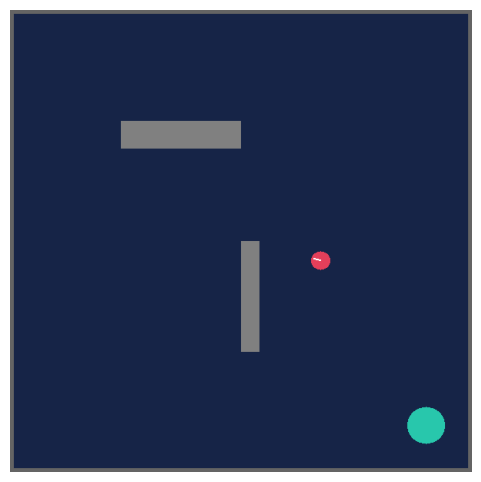

In [ ]:
# Create environment with obstacles in state
env = PointParticleEnv()
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

def run_random_agent_animation(env, steps=500):
    frames = []
    state = env.reset()
    for _ in range(steps):
        # Sample a random action from the continuous action space
        action = env.action_space.sample()
        state, reward, done,_, info = env.step(action)
        frame = env.render(mode='rgb_array')
        frames.append(frame)
        if done:
            break
    return frames

# Create environment instance (with obstacles and continuous actions)
env = PointParticleEnv(obs=True)

# Run the agent for 50 random steps and collect frames
frames = run_random_agent_animation(env, steps=50)

# Create animation using matplotlib
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis('off')
im = ax.imshow(frames[0])

def update(frame):
    im.set_data(frame)
    return [im]

anim = animation.FuncAnimation(fig, update, frames=frames, interval=100, blit=True)

# Display animation as HTML video (for Jupyter notebooks)
HTML(anim.to_html5_video())



In [ ]:
import os
import wandb
import gym
import json
import torch
import numpy as np
from tqdm import tqdm
from src.utils import *
from src.memory import *
from src.agents import *

os.environ['WANDB_API_KEY'] = ''
class Trainer:

    def __init__(self, config_file, enable_logging=True):
        self.enable_logging = enable_logging
        self.config = Trainer.parse_config(config_file)
        self.env =  gym.make(self.config['env_name'])
        self.env = apply_seed(self.env,self.config['seed'])
        self.state_dimension = self.env.observation_space.shape[0]
        print("state",self.state_dimension)
        self.action_dimension = self.env.action_space.shape[0]
        self.max_action = float(self.env.action_space.high[0])
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.agent = DDPGAgent(
            state_dim=self.state_dimension, action_dim=self.action_dimension,
            max_action=self.max_action, device=self.device,
            discount=self.config['discount'], tau=self.config['tau']
        )
        self.save_file_name = f"DDPG_{self.config['env_name']}_{self.config['seed']}"
        self.memory = ReplayBuffer()
        if self.enable_logging:
            wandb.init(project="ddpg", config=self.config)
        try:
            os.mkdir('./pretrained_models')
        except Exception as e:
            pass

    @staticmethod
    def parse_config(json_file):
        with open(json_file, 'r') as f:
            configs = json.load(f)
        return configs

    def train(self):
        state, info = self.env.reset()
        done = False
        episode_reward = 0
        episode_timesteps = 0
        episode_num = 0
        evaluations = []
        episode_rewards = []
        for ts in tqdm(range(1, int(self.config['time_steps']) + 1)):
            episode_timesteps += 1
            if ts < self.config['start_time_step']:
                action = self.env.action_space.sample()
            else:
                action = (
                        self.agent.select_action(np.array(state)) + np.random.normal(
                    0, self.max_action * self.config['expl_noise'],
                    size=self.action_dimension
                )
                ).clip(
                    -self.max_action,
                    self.max_action
                )
            next_state, reward, done, trunc, info = self.env.step(action)
            self.memory.push(
                state, action,reward, next_state,
                float(done) if episode_timesteps < self.env._max_episode_steps else 0)
            state = next_state
            episode_reward += reward
            if ts >= self.config['start_time_step']:
                self.agent.train(self.memory, self.config['batch_size'])
            if done:
                if self.enable_logging:
                    wandb.log({'Episode Reward': episode_reward, 'Timesteps': ts})
                episode_rewards.append(episode_reward)
                state, info = self.env.reset()
                done = False
                episode_reward = 0
                episode_timesteps = 0
                if episode_num % 100 == 0 and episode_num > 0:
                    evaluations.append(evaluate_policy(self.agent, self.config['env_name'], self.config['seed'],enable_logging=self.enable_logging,wandb=wandb))
                    self.agent.save_checkpoint(f"./pretrained_models/{self.save_file_name}")
                episode_num += 1
        wandb.finish()
        return episode_rewards, evaluations

    def evaluate(self):
        self.agent.load_checkpoint(f"./pretrained_models/DDPG_{self.config['env_name']}_{self.config['seed']}")
        evaluate_policy(self.agent, self.config['env_name'], self.config['seed'],render=True)

In [ ]:
# from train import Trainer
from matplotlib import pyplot as plt
import gym
from gym.envs.registration import register
gym.register(
    id='PointParticle-v0',
    entry_point=PointParticleEnv,   # or "__main__:PointParticleEnv"
    max_episode_steps=500    # ← choose a sensible episode length
)


env_name='PointParticle-v0'
trainer = Trainer(config_file=f'./configs/{env_name}.json',enable_logging=True)
episode_rewards, evaluations = trainer.train()

plt.figure(figsize=(16, 10))
plt.plot(episode_rewards)

state 3


/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment PointParticle-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


  0%|          | 0/1000000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
 12%|█▏        | 115032/1000000 [1:00:01<14:22:31, 17.10it/s]